# 1. Importando as bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram, linkage
import requests
import zipfile
import io

# 2. Baixando e carregando os dados

URL dos dados

In [2]:
data_url = "https://files.grouplens.org/datasets/movielens/ml-1m.zip"

Baixar e extrair o arquivo zip

In [3]:
response = requests.get(data_url)
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    zip_ref.extractall("ml-1m")

Carregar os dados

In [4]:
ratings = pd.read_csv('ml-1m/ml-1m/ratings.dat', sep='::', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'], engine='python')

In [5]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [6]:
movies = pd.read_csv('ml-1m/ml-1m/movies.dat', sep='::', header=None, names=['movie_id', 'title', 'genres'], engine='python', encoding='latin1')

In [7]:
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
movies['genres'] = movies['genres'].str.replace('|', ',')
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),"Animation,Children's,Comedy"
1,2,Jumanji (1995),"Adventure,Children's,Fantasy"
2,3,Grumpier Old Men (1995),"Comedy,Romance"
3,4,Waiting to Exhale (1995),"Comedy,Drama"
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
users = pd.read_csv('ml-1m/ml-1m/users.dat', sep='::', header=None, names=['user_id', 'gender', 'age', 'occupation', 'zip_code'], engine='python')

In [10]:
users.head()

,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


# 3. Análise exploratória dos dados

Valores nulos

In [11]:
movies.isnull().sum()

movie_id    0
title       0
genres      0
dtype: int64

In [12]:
ratings.isnull().sum()

user_id      0
movie_id     0
rating       0
timestamp    0
dtype: int64

In [13]:
users.isnull().sum()

user_id       0
gender        0
age           0
occupation    0
zip_code      0
dtype: int64

Informações básicas

In [14]:
print(f'Total de avaliações: {ratings.shape[0]}')
print(f'Total de filmes cadastrados: {movies.shape[0]}')
print(f'Total de usuários: {users.shape[0]}')
print(f'Número de usuários que fizeram alguma avaliação: {ratings["user_id"].nunique()}')
print(f'Número de filmes que receberam alguma avaliação: {ratings["movie_id"].nunique()}')

Total de avaliações: 1000209
Total de filmes cadastrados: 3883
Total de usuários: 6040
Número de usuários que fizeram alguma avaliação: 6040
Número de filmes que receberam alguma avaliação: 3706


Quais filmes foram avaliados?

In [15]:
movies_reviewed = movies[movies['movie_id'].isin(ratings['movie_id'])].copy()
movies_reviewed

,movie_id,title,genres
0,1,Toy Story (1995),"Animation,Children's,Comedy"
1,2,Jumanji (1995),"Adventure,Children's,Fantasy"
2,3,Grumpier Old Men (1995),"Comedy,Romance"
3,4,Waiting to Exhale (1995),"Comedy,Drama"
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [16]:
movies_reviewed['movie_id_true'] = range(1, len(movies_reviewed)+1)
movies_reviewed

,movie_id,title,genres,movie_id_true
0,1,Toy Story (1995),"Animation,Children's,Comedy",1
1,2,Jumanji (1995),"Adventure,Children's,Fantasy",2
2,3,Grumpier Old Men (1995),"Comedy,Romance",3
3,4,Waiting to Exhale (1995),"Comedy,Drama",4
4,5,Father of the Bride Part II (1995),Comedy,5
...,...,...,...,...
3878,3948,Meet the Parents (2000),Comedy,3702
3879,3949,Requiem for a Dream (2000),Drama,3703
3880,3950,Tigerland (2000),Drama,3704
3881,3951,Two Family House (2000),Drama,3705


In [17]:
ratings = ratings.merge(movies_reviewed[['movie_id', 'movie_id_true']], on='movie_id', how='left')
ratings

,user_id,movie_id,rating,timestamp,movie_id_true
0,1,1193,5,978300760,1105
1,1,661,3,978302109,640
2,1,914,3,978301968,854
3,1,3408,4,978300275,3178
4,1,2355,5,978824291,2163
...,...,...,...,...,...
1000204,6040,1091,1,956716541,1020
1000205,6040,1094,5,956704887,1023
1000206,6040,562,5,956704746,549
1000207,6040,1096,4,956715648,1025


In [18]:
num_movies = movies_reviewed['movie_id_true'].nunique()
num_movies

3706

Distribuição das avaliações

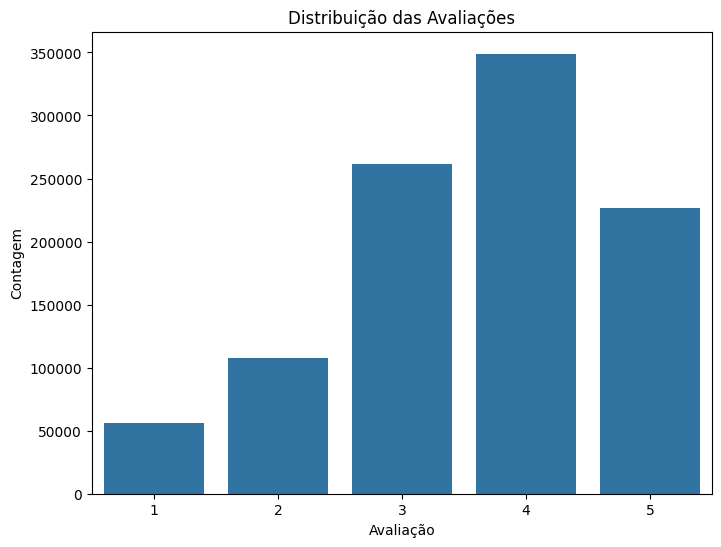

In [19]:
plt.figure(figsize=(8, 6))
sns.countplot(x='rating', data=ratings)
plt.title('Distribuição das Avaliações')
plt.xlabel('Avaliação')
plt.ylabel('Contagem')
plt.show()

Distribuição dos gêneros

C:\Users\wpett\AppData\Local\Temp\ipykernel_17496\3043812017.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, orient='h', palette='viridis')


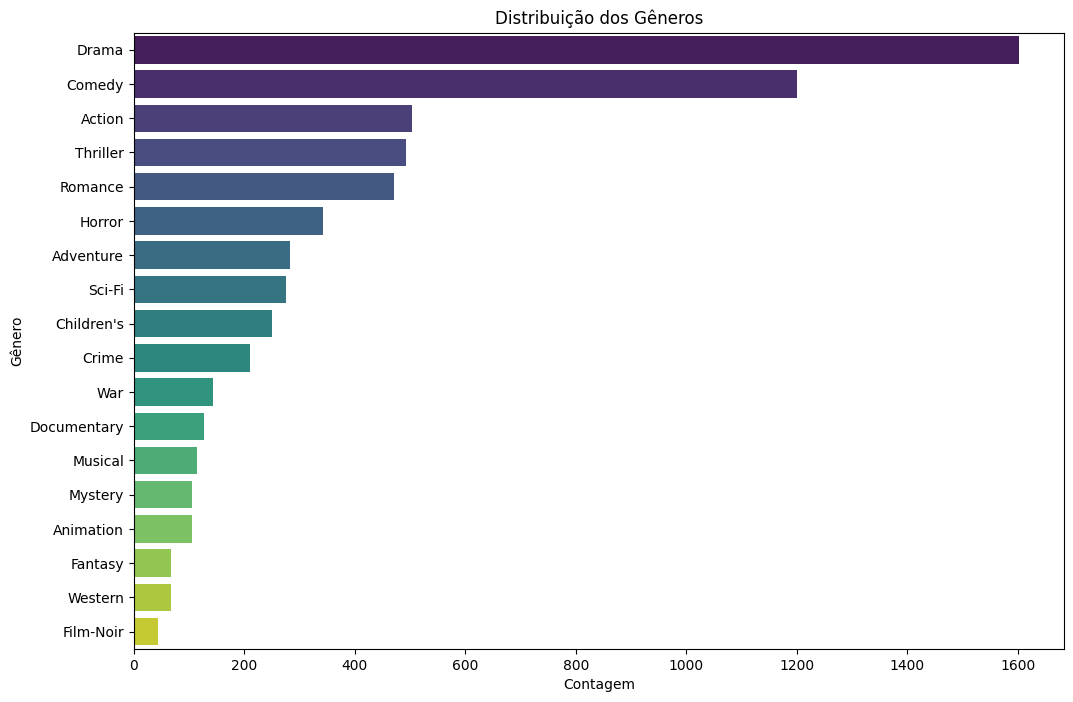

In [20]:
genres = movies['genres'].str.split(',').explode()
genres_list = genres.unique()
genre_counts = genres.value_counts()
plt.figure(figsize=(12, 8))
sns.barplot(x=genre_counts.values, y=genre_counts.index, orient='h', palette='viridis')
plt.title('Distribuição dos Gêneros')
plt.xlabel('Contagem')
plt.ylabel('Gênero')
plt.show()

Quantidade de filmes por ano

C:\Users\wpett\AppData\Local\Temp\ipykernel_17496\4137072900.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=movies_years_count.index, y=movies_years_count.values, palette="viridis")


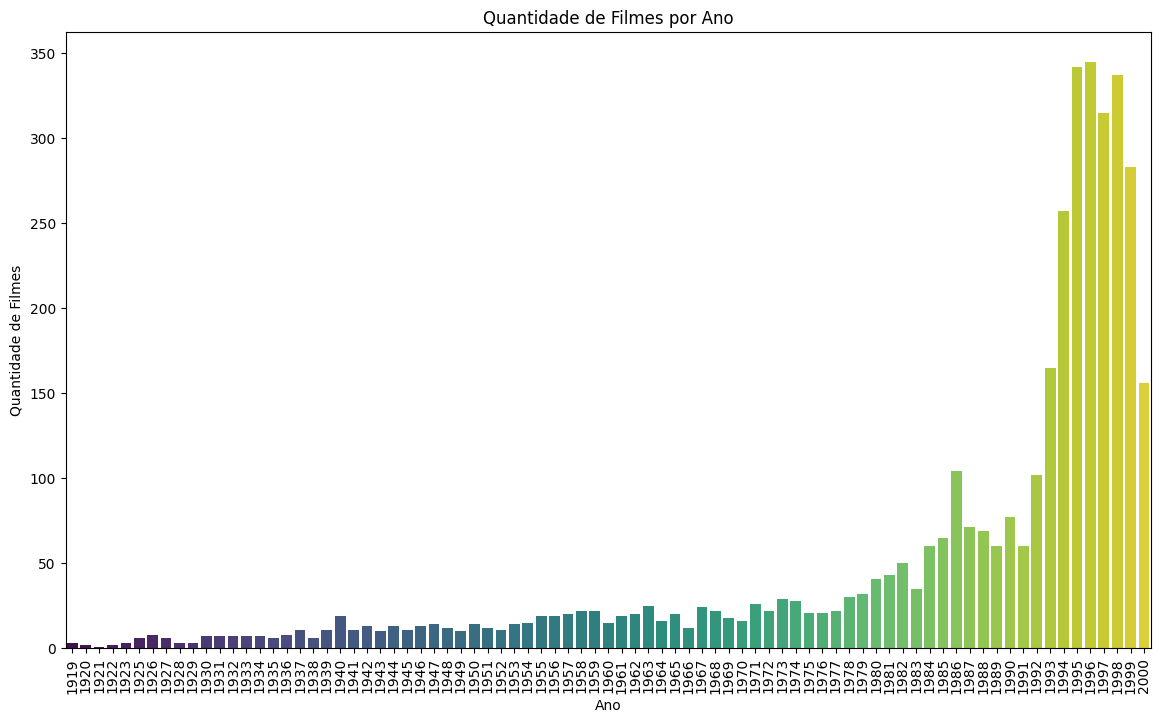

In [21]:
# Extrair o ano de lançamento do título do filme
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)')

# Verificar a distribuição dos anos
movies['year'] = movies['year'].astype(int)
movies_years_count = movies['year'].value_counts().sort_index()

# Plotar a quantidade de filmes por ano
plt.figure(figsize=(14, 8))
sns.barplot(x=movies_years_count.index, y=movies_years_count.values, palette="viridis")
plt.title('Quantidade de Filmes por Ano')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Filmes')
plt.xticks(rotation=90)
plt.show()

# 4. Pré-processamento dos dados

Algum usuário avaliou algum filme mais de uma vez?

In [22]:
duplicated_ratings = ratings.duplicated(subset=['user_id', 'movie_id'])
num_duplicated_ratings = duplicated_ratings.sum()
print(f'Número de vezes que um usuário avaliou um filme mais de uma vez: {num_duplicated_ratings}')

Número de vezes que um usuário avaliou um filme mais de uma vez: 0


Há algum filme duplicado?

In [23]:
duplicated_movies = movies.duplicated()
num_duplicated_movies = duplicated_movies.sum()
print(f'Filmes duplicados: {num_duplicated_movies}')

Filmes duplicados: 0


Criando a matriz de classificação, onde as linhas são os filmes e as colunas são as avaliações

In [44]:
ratings_matrix = np.empty((movies_reviewed.shape[0], users.shape[0]))
ratings_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [45]:
ratings_matrix[:] = np.nan
ratings_matrix

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [46]:
for index, row in ratings.iterrows():
    ratings_matrix[row['movie_id_true']-1][row['user_id']-1] = row['rating']

ratings_matrix

array([[ 5., nan, nan, ..., nan, nan,  3.],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [47]:
ratings_matrix.shape

(3706, 6040)

In [48]:
def replace_nans_with_row_mean(matrix):
    for i in range(matrix.shape[0]):
        row = matrix[i, :]
        mean_value = np.nanmean(row)
        row[np.isnan(row)] = mean_value
    return matrix

In [49]:
ratings_matrix = replace_nans_with_row_mean(ratings_matrix)
ratings_matrix

array([[5.        , 4.14684641, 4.14684641, ..., 4.14684641, 4.14684641,
        3.        ],
       [3.20114123, 3.20114123, 3.20114123, ..., 3.20114123, 3.20114123,
        3.20114123],
       [3.0167364 , 3.0167364 , 3.0167364 , ..., 3.0167364 , 3.0167364 ,
        3.0167364 ],
       ...,
       [3.66666667, 3.66666667, 3.66666667, ..., 3.66666667, 3.66666667,
        3.66666667],
       [3.9       , 3.9       , 3.9       , ..., 3.9       , 3.9       ,
        3.9       ],
       [3.78092784, 3.78092784, 3.78092784, ..., 3.78092784, 3.78092784,
        3.78092784]])

Aparentemente, alguns filmes tiveram a mesma nota para todos os usuários, fazendo com que o desvio padrão seja 0. Por isso, irei atribuir um valor nulo nesses casos.

In [50]:
def normalize_row(row):
    mean = np.mean(row)
    std = np.std(row)
    mean = np.nanmean(row)
    std = np.nanstd(row)
    if std == 0:
        return np.zeros_like(row)  # Substituir por zeros se o desvio padrão for zero
    return (row - mean) / std
    return (row - mean) / std

In [52]:
ratings_matrix_normalized = np.apply_along_axis(normalize_row, 1, ratings_matrix)
ratings_matrix_normalized

array([[ 1.70731838e+00,  1.77740956e-15,  1.77740956e-15, ...,
         1.77740956e-15,  1.77740956e-15, -2.29505214e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 4.53184131e-15,  4.53184131e-15,  4.53184131e-15, ...,
         4.53184131e-15,  4.53184131e-15,  4.53184131e-15],
       [ 5.22691510e-15,  5.22691510e-15,  5.22691510e-15, ...,
         5.22691510e-15,  5.22691510e-15,  5.22691510e-15],
       [ 5.62870295e-15,  5.62870295e-15,  5.62870295e-15, ...,
         5.62870295e-15,  5.62870295e-15,  5.62870295e-15]])

In [53]:
total_nans = np.isnan(ratings_matrix_normalized).sum()
print(f"Número total de NaNs: {total_nans}")

Número total de NaNs: 0


# 5. Cálculo das Matrizes de Distâncias

Criando a matriz de utilidade (matriz usuário-filme)

In [30]:
user_movie_matrix = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)

Fazendo a matriz de distância filme-filme

In [31]:
distance_matrix = pairwise_distances(user_movie_matrix.T, metric='euclidean')

# 6. Aplicações dos algoritmos de clusterização

## 6.1. K-Means

In [32]:
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans_labels = kmeans.fit_predict(distance_matrix)

C:\Users\wpett\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [33]:
kmeans_labels

array([9, 8, 0, ..., 1, 1, 0])

In [34]:
np.unique(kmeans_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 327,  752,  103,  207,   22,  542, 1030,  423,  261,   39],
       dtype=int64))

## 6.2. DBSCAN

In [35]:
dbscan = DBSCAN(eps=5, min_samples=5, metric='precomputed')
dbscan_labels = dbscan.fit_predict(distance_matrix)

In [36]:
dbscan_labels

array([-1, -1, -1, ..., -1, -1, -1], dtype=int64)

In [37]:
np.unique(dbscan_labels, return_counts=True)

(array([-1,  0], dtype=int64), array([3473,  233], dtype=int64))

## 6.3. Clustering Hierárquico

In [38]:
hierarchical = AgglomerativeClustering(n_clusters=10, metric='precomputed', linkage='average')
hierarchical_labels = hierarchical.fit_predict(distance_matrix)

In [39]:
hierarchical_labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [40]:
np.unique(hierarchical_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),
 array([3685,    2,    7,    2,    2,    4,    1,    1,    1,    1],
       dtype=int64))